In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import scanpy as sc
import stagate
import matplotlib.pyplot as plt
from stagate.Train_STAGATE import train_STAGATE
from stagate.utils import Cal_Spatial_Net
import stagate.stagate_func as SGT

import tensorflow.compat.v1 as tf

2024-06-07 18:27:40.614355: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-07 18:27:40.785330: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-07 18:27:41.374333: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Import Phillips data

In [21]:
phillips = pd.read_excel('./41467_2021_26974_MOESM3_ESM_-_Objects.xlsx')

In [4]:
display(phillips)

,Count,EventCount,Index in File,ClusterID,FileName,ClusterName,Spots,Patients,Groups,FOXP3,...,PD-1+CD8+,CD4+Tcells,PD-1+tumor,CD8+Tcells,Ki67+CD4+,Ki-67+Tregs,ICOS+Tregs,IDO+Tregs,Ki67+tumor,original_index
0,0,1,60,33987,reg001,B cells,1,1,1,0.692403,...,0,0,0,0,0,0,0,0,0,0
1,1,1,94,33987,reg001,B cells,1,1,1,8.094747,...,0,0,0,0,0,0,0,0,0,1
2,2,1,198,33987,reg001,B cells,1,1,1,4.110389,...,0,0,0,0,0,0,0,0,0,2
3,3,1,284,33987,reg001,B cells,1,1,1,0.000000,...,0,0,0,0,0,0,0,0,0,3
4,4,1,298,33987,reg001,B cells,1,1,1,2.937673,...,0,0,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117165,116917,1,633,33981,reg066,vasculature,66,14,4,84.269714,...,0,0,0,0,0,0,0,0,0,116917
117166,116918,1,677,33981,reg066,vasculature,66,14,4,56.425945,...,0,0,0,0,0,0,0,0,0,116918
117167,116919,1,681,33981,reg066,vasculature,66,14,4,63.152092,...,0,0,0,0,0,0,0,0,0,116919
117168,116920,1,705,33981,reg066,vasculature,66,14,4,66.873306,...,0,0,0,0,0,0,0,0,0,116920


# Plot coordinates with different colors for cell types

## Select a random FileName (region)

In [5]:
random_sample = phillips["FileName"].sample(n=1).iloc[0]
print("Random patient selected:", random_sample)
filtered_phillips = phillips[phillips["FileName"] == random_sample]
display(filtered_phillips)
print(phillips.columns)

Random patient selected: reg058


,Count,EventCount,Index in File,ClusterID,FileName,ClusterName,Spots,Patients,Groups,FOXP3,...,PD-1+CD8+,CD4+Tcells,PD-1+tumor,CD8+Tcells,Ki67+CD4+,Ki-67+Tregs,ICOS+Tregs,IDO+Tregs,Ki67+tumor,original_index
366,1357,1,28,33987,reg058,B cells,58,14,2,44.482403,...,0,0,0,0,0,0,0,0,0,1357
367,1358,1,61,33987,reg058,B cells,58,14,2,22.863396,...,0,0,0,0,0,0,0,0,0,1358
368,1359,1,66,33987,reg058,B cells,58,14,2,93.857559,...,0,0,0,0,0,0,0,0,0,1359
369,1360,1,170,33987,reg058,B cells,58,14,2,39.765587,...,0,0,0,0,0,0,0,0,0,1360
370,1361,1,724,33987,reg058,B cells,58,14,2,0.000000,...,0,0,0,0,0,0,0,0,0,1361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113901,116148,1,1241,33981,reg058,vasculature,58,14,2,0.000000,...,0,0,0,0,0,0,0,0,0,116148
113902,116149,1,1251,33981,reg058,vasculature,58,14,2,42.773430,...,0,0,0,0,0,0,0,0,0,116149
113903,116150,1,1798,33981,reg058,vasculature,58,14,2,0.000000,...,0,0,0,0,0,0,0,0,0,116150
113904,116151,1,1828,33981,reg058,vasculature,58,14,2,100.574509,...,0,0,0,0,0,0,0,0,0,116151


Index(['Count', 'EventCount', 'Index in File', 'ClusterID', 'FileName',
       'ClusterName', 'Spots', 'Patients', 'Groups', 'FOXP3',
       ...
       'PD-1+CD8+', 'CD4+Tcells', 'PD-1+tumor', 'CD8+Tcells', 'Ki67+CD4+',
       'Ki-67+Tregs', 'ICOS+Tregs', 'IDO+Tregs', 'Ki67+tumor',
       'original_index'],
      dtype='object', length=121)


## Plot coordinates to see one FileName (region)

/tmp/ipykernel_622696/2298176563.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data= filtered_phillips,


<Axes: xlabel='X', ylabel='Y'>

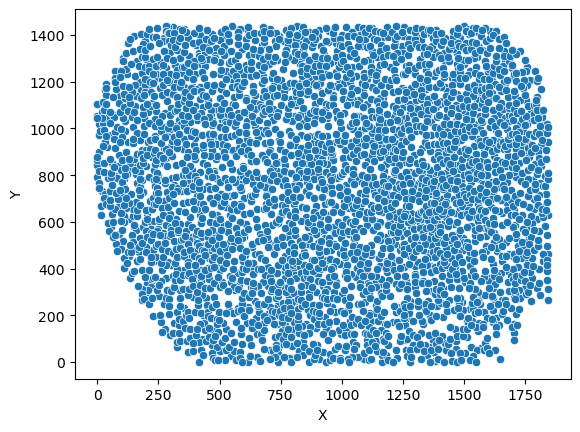

In [12]:
sns.scatterplot(data= filtered_phillips,
           x = "X", 
           y = "Y",
        #    hue= "ClusterName",
           palette="pastel")

<Axes: xlabel='X', ylabel='Y'>

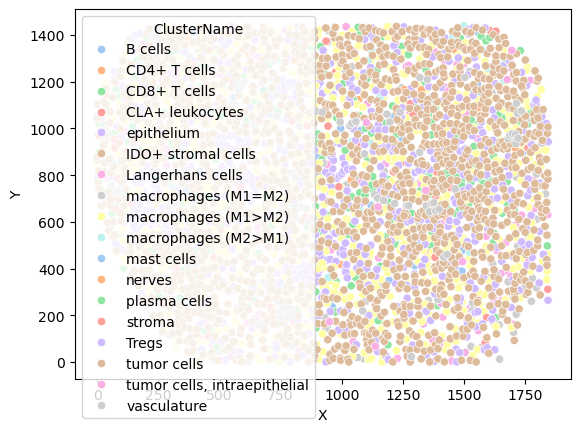

In [13]:
sns.scatterplot(data= filtered_phillips,
           x = "X", 
           y = "Y",
           hue= "ClusterName",
           palette="pastel")

# Run Stagate niche detection

## Subset filtered_phillips to store values in AnnData object

In [28]:
# Columns name and indices

for index, column_name in enumerate(filtered_phillips.columns):
    print(f"Index: {index}, Column name: {column_name}")

marker_col_names = ['FOXP3', 'GATA3', 'MUC-1', 'Vimentin', 'T-bet', 'CD62L', 'Cytokeratin', 'PD-L1', 'Ki-67', 'CD15', 'CD30', 'CD2', 'GranzymeB', 'CD5', 'CD39', 'MMP9', 'CD4', 'LAG3', 'CD25', 'CD56', 'CD20', 'PD-1', 'CD11c', 'CLA-CD162', 'IDO-1', 'VISTA', 'HLA-DR', 'ICOS', 'BCL-2', 'CD3', 'CD69', 'CD8', 'CD7', 'CD45RA', 'CD45', 'CD1a', 'CD57', 'B-catenin', 'CD45RO', 'CD71', 'CD34', 'CD68', 'CD38', 'CollagenIV', 'CD31', 'Podoplanin', 'CD138', 'CD163', 'Mastcell-tryptase', 'MMP12', 'CD164', 'p53', 'CCR6', 'CD16', 'CD11b', 'CCR4', 'EGFR', 'HOECHST1:Cyc_1_ch_1', 'DRAQ5']
coord_col_names = ['X', 'Y']
cell_types_names = ['ClusterName']

Index: 0, Column name: Count
Index: 1, Column name: EventCount
Index: 2, Column name: Index in File
Index: 3, Column name: ClusterID
Index: 4, Column name: FileName
Index: 5, Column name: ClusterName
Index: 6, Column name: Spots
Index: 7, Column name: Patients
Index: 8, Column name: Groups
Index: 9, Column name: FOXP3
Index: 10, Column name: GATA3
Index: 11, Column name: MUC-1
Index: 12, Column name: Vimentin
Index: 13, Column name: T-bet
Index: 14, Column name: CD62L
Index: 15, Column name: Cytokeratin
Index: 16, Column name: PD-L1
Index: 17, Column name: Ki-67
Index: 18, Column name: CD15
Index: 19, Column name: CD30
Index: 20, Column name: CD2
Index: 21, Column name: GranzymeB
Index: 22, Column name: CD5
Index: 23, Column name: CD39
Index: 24, Column name: MMP9
Index: 25, Column name: CD4
Index: 26, Column name: LAG3
Index: 27, Column name: CD25
Index: 28, Column name: CD56
Index: 29, Column name: CD20
Index: 30, Column name: PD-1
Index: 31, Column name: CD11c
Index: 32, Column name

In [29]:
# Subsetting the filtered Phillips

df_markers = filtered_phillips.loc[:,marker_col_names]
df_coords = filtered_phillips.loc[:,coord_col_names]
df_cell_types = filtered_phillips.loc[:,cell_types_names]

display(df_markers)
display(df_coords)
display(df_cell_types)

,FOXP3,GATA3,MUC-1,Vimentin,T-bet,CD62L,Cytokeratin,PD-L1,Ki-67,CD15,...,MMP12,CD164,p53,CCR6,CD16,CD11b,CCR4,EGFR,HOECHST1:Cyc_1_ch_1,DRAQ5
1831,0.000000,143.915695,55.719318,26.723610,464.346893,120.353745,28.594275,1219.359985,0.000000,1.390000e-10,...,482.126282,2040.491455,969.076294,1111.771362,8388.618164,951.267517,2382.646973,1284.989868,3557.437500,2756.846436
1832,92.705368,150.928879,141.804062,1118.722778,1677.075439,396.420898,0.000000,704.917297,69.767776,0.000000e+00,...,342.214813,1523.490601,1771.509399,3327.136475,1398.927490,745.285950,4584.696777,1403.463013,2079.300537,2183.895508
1833,356.898041,105.237282,714.530457,698.723389,1004.597961,334.040100,0.000000,935.300171,16.900370,0.000000e+00,...,435.556671,3664.803467,1852.568848,2763.483154,2517.444336,680.336975,2270.500977,1346.879028,2962.831543,2315.349121
1834,85.917625,133.083206,611.442139,740.843445,1456.322144,375.025971,0.018502,1135.261230,43.610992,5.000000e-08,...,492.762970,2379.948730,2186.045410,3714.578857,3764.258057,774.681274,2141.781006,1289.277466,4617.596680,3856.589844
1835,52.040569,81.211906,263.523682,575.699036,1282.155518,470.467133,5.528502,902.379822,0.000000,6.085462e-01,...,538.073364,4788.322754,1842.210083,2422.578613,5739.450684,832.847961,3699.215820,1643.124512,4075.147705,3321.567627
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116859,65.869370,78.559097,61.658699,739.162537,902.640991,408.133392,0.000000,676.016113,47.784126,1.620000e-10,...,415.508331,440.929260,1449.189819,1865.070435,1237.385376,1349.604858,7277.965332,1556.888306,1417.995605,1547.472656
116860,0.000000,0.000000,32.255104,476.819244,295.470581,185.783417,0.000000,930.355591,0.000000,5.790000e-10,...,439.769958,0.000000,1076.207886,1480.717651,1174.508179,1623.174072,11597.041020,1760.350098,1771.889404,1279.070801
116861,54.212509,58.982204,126.871109,1440.369263,515.056397,192.221542,0.000000,552.367615,5.653559,1.480000e-11,...,306.690613,110.892983,1353.763672,990.081787,939.589539,1154.936523,6628.058105,1332.961304,913.612915,1163.304932
116862,45.824348,164.355957,82.879669,1183.327271,1073.227417,344.295349,1.013459,606.113586,0.000000,0.000000e+00,...,252.547257,1242.183838,1532.747803,1257.774536,1649.142456,502.275482,2769.531494,1238.506348,2058.927490,1902.930664


,X,Y
1831,349,913
1832,420,814
1833,554,1104
1834,559,1134
1835,646,1011
...,...,...
116859,1713,935
116860,1722,958
116861,1719,1065
116862,1715,1107


,ClusterName
1831,B cells
1832,B cells
1833,B cells
1834,B cells
1835,B cells
...,...
116859,vasculature
116860,vasculature
116861,vasculature
116862,vasculature


## AnnData Object and Niches detection

/home/francesco.massaini/.local/bin/miniforge3/envs/mosna-gpu/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/francesco.massaini/.local/bin/miniforge3/envs/mosna-gpu/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:72: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


An Anndata object is created for spot reg061
------Calculating spatial graph...


2024-05-30 12:05:57.764534: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-05-30 12:05:57.764608: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: crct2128
2024-05-30 12:05:57.764611: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: crct2128
2024-05-30 12:05:57.764813: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 550.54.15
2024-05-30 12:05:57.764822: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 550.54.15
2024-05-30 12:05:57.764824: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:248] kernel version seems to match DSO: 550.54.15
2024-05-30 12:05:57.767941: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


The graph contains 34826 edges, 3437 cells.
10.1327 neighbors per cell on average.
Size of Input:  (3437, 59)


100%|██████████| 500/500 [00:24<00:00, 20.81it/s]


Features are made and added to Anndata object for spot reg061
Number of unique clusters: 8
Louvain clustering has been performed on Anndata object for spot reg061
We show the Anndata object prior to niche visualization for spot reg061
AnnData object with n_obs × n_vars = 3437 × 59
    obs: 'cell_type', 'louvain'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'Spatial_Net', 'neighbors', 'umap', 'louvain'
    obsm: 'spatial', 'niches_vectors', 'X_umap'
    obsp: 'distances', 'connectivities'
[[  0.          27.09344731  10.48967185 ... 241.911108   669.72018122
  519.00158323]
 [ 12.69323035  20.66520057  19.41582953 ... 192.16232766 284.69808424
  299.01924048]
 [ 64.40282982  18.99023804 128.93817879 ... 243.04650325 534.64775327
  417.80850096]
 ...
 [ 12.54843921  13.65246912  29.36655071 ... 308.53734973 211.47178589
  269.26739701]
 [ 13.02138283  46.70315912  23.550971   ... 351.93223352 585.06195901
  540.73411888]
 [  5

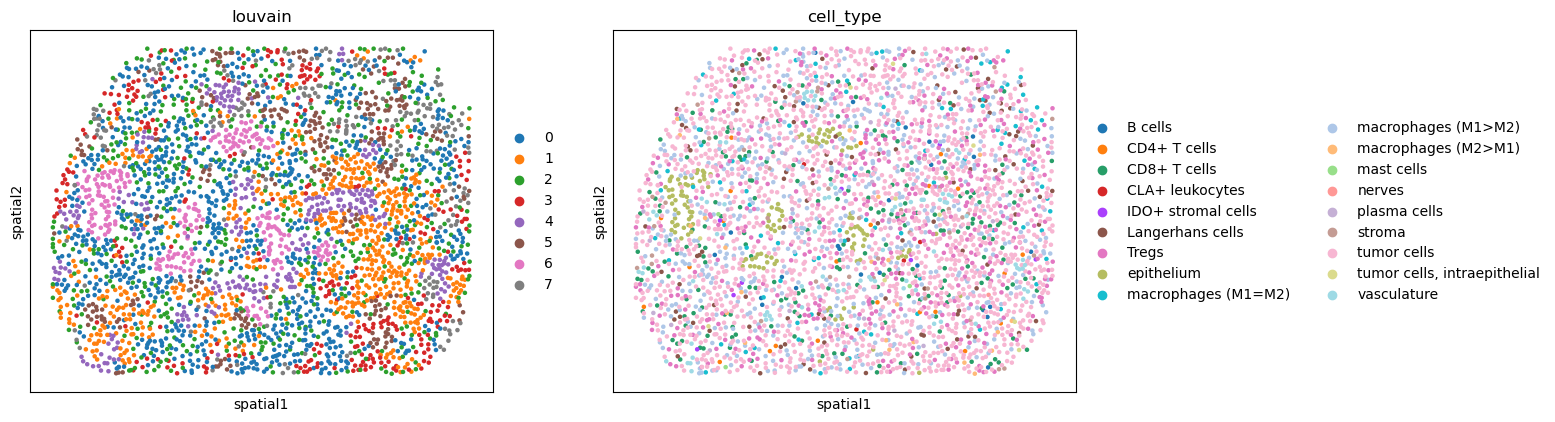

Niche detection has been performed without errors for spot reg061


In [31]:
spot = random_sample  # Spot column and random sample (FileName) should be the same thing 

## Create AnnData Object
adata_object = sc.AnnData(df_markers)
adata_object.obsm['spatial'] = df_coords.values
cell_types = df_cell_types['ClusterName']
adata_object.obs["cell_type"] = pd.Categorical(cell_types)

print(f"An Anndata object is created for spot {spot}")

# Perform feature generation and add features to the Anndata object
adata_with_features = SGT.make_features_STARGATE(adata_object)
print(f"Features are made and added to Anndata object for spot {spot}")

# Perform Louvain clustering on the Anndata object
adata_with_louvain_clustering = SGT.clustering_louvain(adata_object)
print(f"Louvain clustering has been performed on Anndata object for spot {spot}")

# Perform niche visualization
print(f"We show the Anndata object prior to niche visualization for spot {spot}")
print(adata_object)
print(adata_object.X)
SGT.niches_visualization(adata_with_louvain_clustering)
print(f"Niche detection has been performed without errors for spot {spot}")

,cell_type,louvain,freq
0,tumor cells,0,372
1,tumor cells,1,325
2,tumor cells,2,321
3,macrophages (M1>M2),0,282
4,tumor cells,3,192
...,...,...,...
98,CD4+ T cells,3,1
99,stroma,7,1
100,macrophages (M2>M1),6,1
101,nerves,2,1


cell_type,B cells,CD4+ T cells,CD8+ T cells,CLA+ leukocytes,IDO+ stromal cells,Langerhans cells,Tregs,epithelium,macrophages (M1=M2),macrophages (M1>M2),macrophages (M2>M1),mast cells,nerves,plasma cells,stroma,tumor cells,"tumor cells, intraepithelial",vasculature
louvain,,,,,,,,,,,,,,,,,,
0,6.0,4.0,26.0,3.0,4.0,37.0,109.0,2.0,50.0,282.0,11.0,NaN,NaN,6.0,9.0,372.0,2.0,1.0
1,8.0,8.0,62.0,NaN,2.0,8.0,109.0,2.0,9.0,64.0,3.0,NaN,NaN,3.0,4.0,325.0,NaN,1.0
2,3.0,7.0,57.0,1.0,NaN,5.0,93.0,6.0,9.0,52.0,2.0,NaN,1.0,4.0,7.0,321.0,2.0,4.0
3,1.0,1.0,24.0,NaN,NaN,3.0,37.0,1.0,3.0,28.0,2.0,2.0,NaN,NaN,5.0,192.0,3.0,2.0
4,5.0,3.0,32.0,NaN,1.0,NaN,20.0,NaN,NaN,24.0,NaN,NaN,NaN,3.0,14.0,115.0,1.0,74.0
5,2.0,NaN,7.0,NaN,NaN,41.0,25.0,NaN,13.0,89.0,NaN,NaN,NaN,1.0,NaN,91.0,1.0,NaN
6,NaN,NaN,4.0,1.0,1.0,2.0,8.0,131.0,2.0,34.0,1.0,NaN,NaN,NaN,2.0,49.0,NaN,NaN
7,NaN,NaN,5.0,NaN,NaN,19.0,25.0,1.0,8.0,42.0,3.0,1.0,NaN,2.0,1.0,122.0,1.0,NaN


Text(0.5, 1.0, 'Normalized by column')

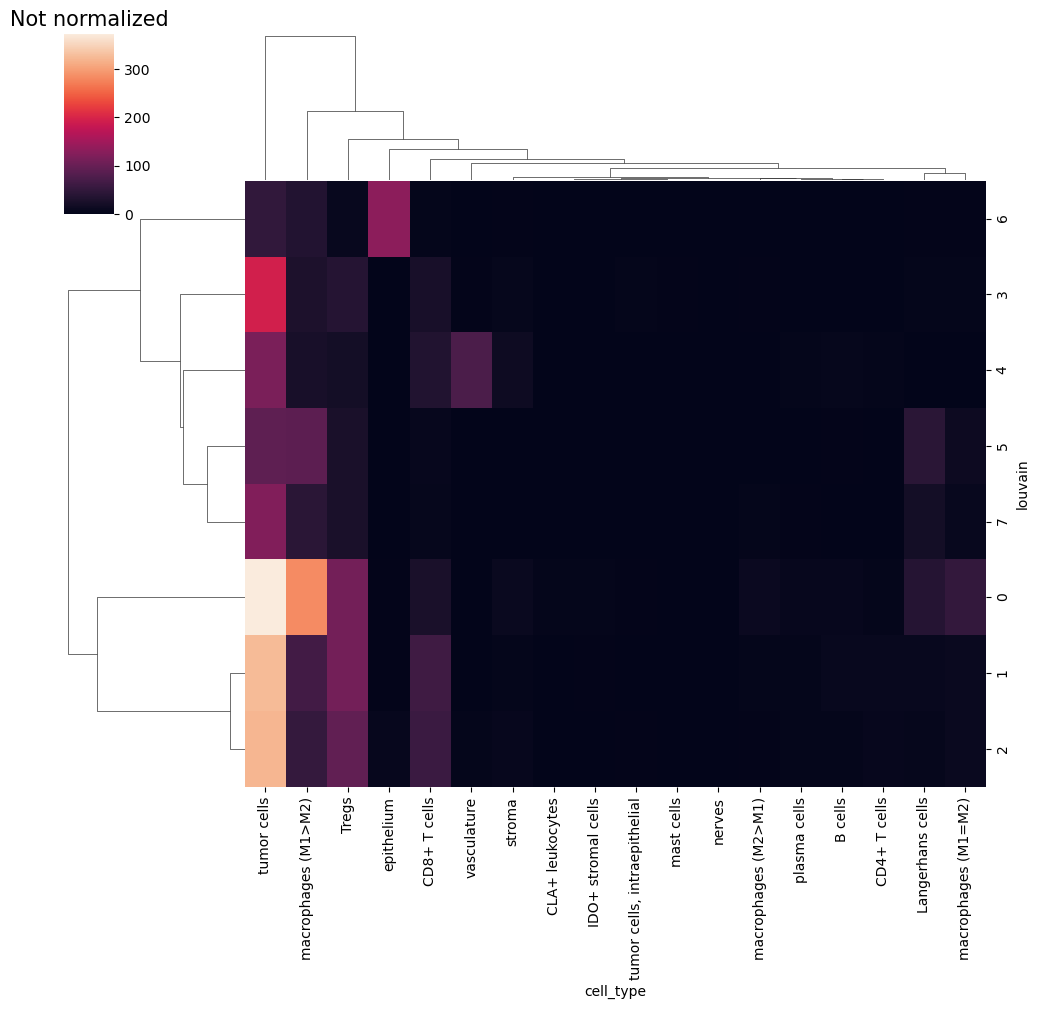

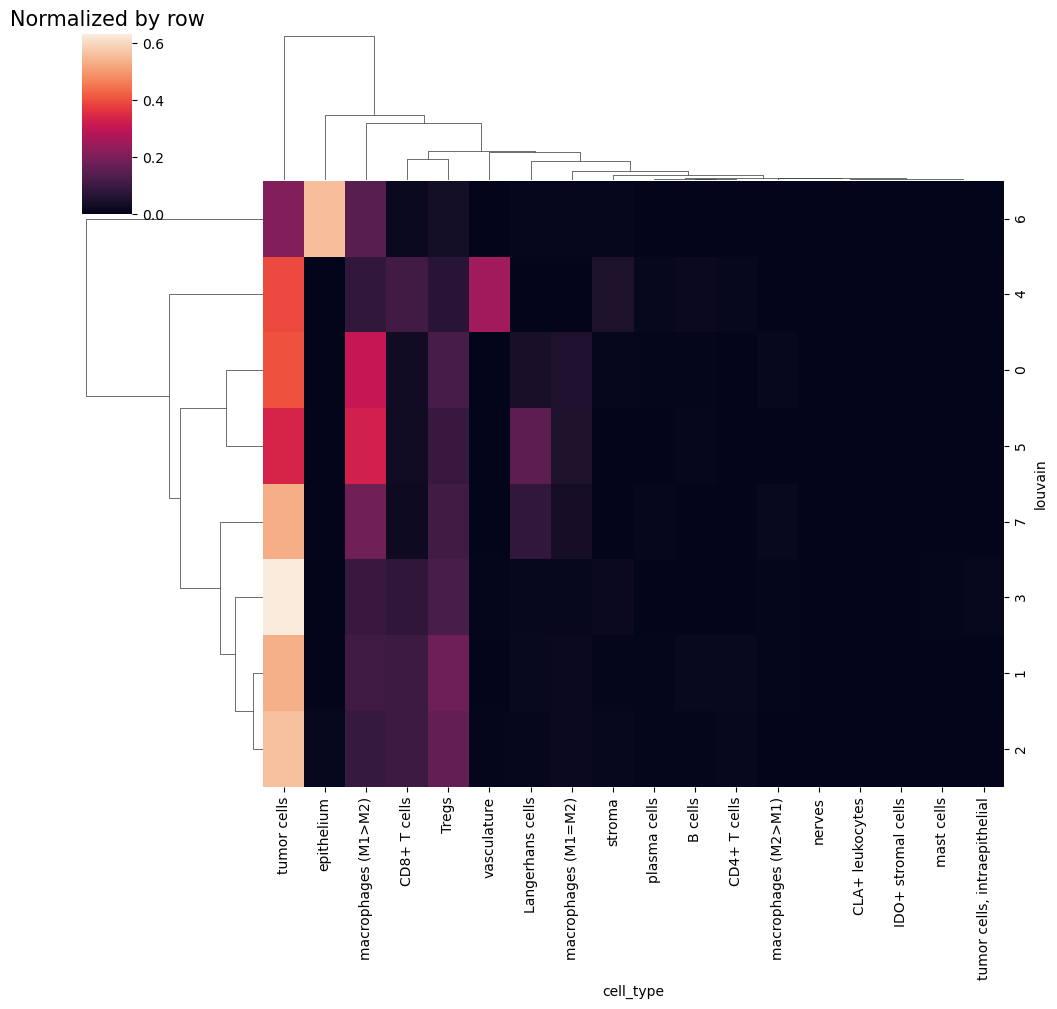

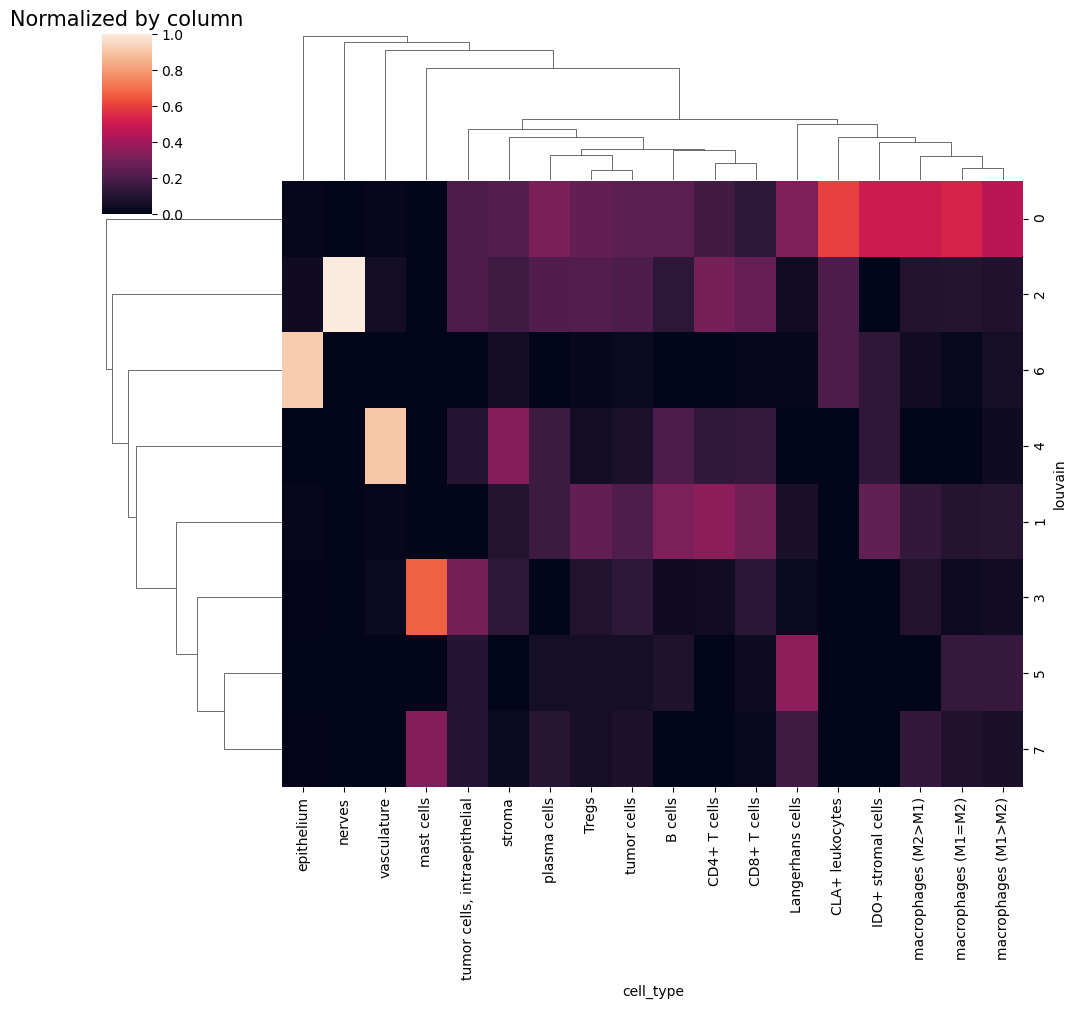

In [92]:
# Store anndata result into a df
df_louvain_celltypes = pd.DataFrame(adata_with_louvain_clustering.obs.value_counts()).reset_index()
df_louvain_celltypes.columns = ['cell_type', 'louvain', 'freq']

display(df_louvain_celltypes)

# let's make a pivot table of this df 
matrix_count = df_louvain_celltypes.pivot_table(columns= 'cell_type', index= 'louvain' , values= 'freq')
display(matrix_count)
sns.clustermap(matrix_count.fillna(0))
plt.title('Not normalized', size=15)

# normalization by row
row_normalized_matrix = matrix_count.div(matrix_count.sum(axis=1), axis=0)
sns.clustermap(row_normalized_matrix.fillna(0))
plt.title('Normalized by row', size=15)

# normalization by column
column_normalized_matrix = matrix_count.div(matrix_count.sum(axis=0), axis=1)
sns.clustermap(column_normalized_matrix.fillna(0))
plt.title('Normalized by column', size=15)


# Stitching Samples

In [42]:
phillips = pd.read_excel('./41467_2021_26974_MOESM3_ESM_-_Objects.xlsx')

# Columns name and indices

for index, column_name in enumerate(phillips.columns):
    print(f"Index: {index}, Column name: {column_name}")

marker_col_names = ['FOXP3', 'GATA3', 'MUC-1', 'Vimentin', 'T-bet', 'CD62L', 'Cytokeratin', 'PD-L1', 'Ki-67', 'CD15', 'CD30', 'CD2', 'GranzymeB', 'CD5', 'CD39', 'MMP9', 'CD4', 'LAG3', 'CD25', 'CD56', 'CD20', 'PD-1', 'CD11c', 'CLA-CD162', 'IDO-1', 'VISTA', 'HLA-DR', 'ICOS', 'BCL-2', 'CD3', 'CD69', 'CD8', 'CD7', 'CD45RA', 'CD45', 'CD1a', 'CD57', 'B-catenin', 'CD45RO', 'CD71', 'CD34', 'CD68', 'CD38', 'CollagenIV', 'CD31', 'Podoplanin', 'CD138', 'CD163', 'Mastcell-tryptase', 'MMP12', 'CD164', 'p53', 'CCR6', 'CD16', 'CD11b', 'CCR4', 'EGFR', 'HOECHST1:Cyc_1_ch_1', 'DRAQ5']
coord_col_names = ['X', 'Y']
cell_types_names = ['ClusterName']
metadata_col_names = ["Count", "FileName", "Patients", "Groups"]


# Subsetting the dataset 
df_markers = phillips.loc[:,marker_col_names]
df_coords = phillips.loc[:,coord_col_names]
df_cell_types = phillips.loc[:,cell_types_names]

display(df_markers)
display(df_coords)
display(df_cell_types)



Index: 0, Column name: Count
Index: 1, Column name: EventCount
Index: 2, Column name: Index in File
Index: 3, Column name: ClusterID
Index: 4, Column name: FileName
Index: 5, Column name: ClusterName
Index: 6, Column name: Spots
Index: 7, Column name: Patients
Index: 8, Column name: Groups
Index: 9, Column name: FOXP3
Index: 10, Column name: GATA3
Index: 11, Column name: MUC-1
Index: 12, Column name: Vimentin
Index: 13, Column name: T-bet
Index: 14, Column name: CD62L
Index: 15, Column name: Cytokeratin
Index: 16, Column name: PD-L1
Index: 17, Column name: Ki-67
Index: 18, Column name: CD15
Index: 19, Column name: CD30
Index: 20, Column name: CD2
Index: 21, Column name: GranzymeB
Index: 22, Column name: CD5
Index: 23, Column name: CD39
Index: 24, Column name: MMP9
Index: 25, Column name: CD4
Index: 26, Column name: LAG3
Index: 27, Column name: CD25
Index: 28, Column name: CD56
Index: 29, Column name: CD20
Index: 30, Column name: PD-1
Index: 31, Column name: CD11c
Index: 32, Column name

,FOXP3,GATA3,MUC-1,Vimentin,T-bet,CD62L,Cytokeratin,PD-L1,Ki-67,CD15,...,MMP12,CD164,p53,CCR6,CD16,CD11b,CCR4,EGFR,HOECHST1:Cyc_1_ch_1,DRAQ5
0,0.692403,80.418777,81.578133,0.422483,1281.423706,300.485474,0.025324,154.115509,21.706610,0.000000,...,932.848084,2017.046997,1452.009888,1666.669556,1692.139648,729.536743,980.480530,2174.919678,3520.529297,4133.993164
1,8.094747,75.731651,113.700844,48.759071,871.266174,727.925598,6.335735,158.100159,0.000000,3.918327,...,808.271423,2883.205811,1766.072021,1818.412964,2158.456299,4201.670898,2979.158447,1702.522217,2368.385986,2178.956055
2,4.110389,120.782913,92.355637,718.113159,541.268494,634.931030,0.000000,1358.853149,19.519222,0.000000,...,696.024475,3790.150391,1198.464722,6729.749023,1725.925171,601.758179,2999.567627,1925.974609,2814.299561,2295.584229
3,0.000000,51.528435,66.819679,47.125046,1029.719727,441.645203,0.000000,179.429733,22.709156,0.000000,...,763.677307,4075.999023,1284.326294,1321.358398,1140.679688,660.061523,1081.780029,1503.303955,2369.906738,1571.952026
4,2.937673,76.295013,136.434204,88.958450,528.213989,745.576172,25.205679,195.440445,36.913433,0.494460,...,910.665527,8478.983398,1950.192505,2833.836670,703.584473,203.676590,767.187683,1224.029053,3678.256348,2814.730713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117165,84.269714,66.498177,145.539215,2301.924316,885.243774,618.053589,0.000000,371.721130,7.939903,0.000000,...,470.894318,826.211304,1687.433472,2375.839600,1916.857666,793.478272,2207.129883,1498.993652,2738.338379,2844.052490
117166,56.425945,34.043579,78.483635,1927.676147,900.688416,491.037872,0.000000,145.657364,0.000000,0.000000,...,382.937408,330.187317,1274.760864,1948.127075,732.317993,832.146606,1370.911987,1171.960205,1311.130493,1783.542969
117167,63.152092,56.427765,41.117233,1339.845703,710.644409,420.437378,0.000000,59.120216,0.000000,0.000000,...,750.833313,2283.984619,1785.317261,2270.334717,1567.738037,1115.824463,2910.369385,2182.663330,5116.273926,4646.400391
117168,66.873306,85.025856,66.847565,1905.233032,5366.962402,880.648682,0.000000,60.661129,0.000000,0.000000,...,423.519501,3307.445068,1775.024902,1790.126953,6193.992188,3188.485840,2185.574707,2260.572266,1145.774536,1893.452637


,X,Y
0,165,979
1,219,859
2,328,1105
3,422,120
4,415,870
...,...,...
117165,1594,222
117166,1639,635
117167,1637,657
117168,1658,761


,ClusterName
0,B cells
1,B cells
2,B cells
3,B cells
4,B cells
...,...
117165,vasculature
117166,vasculature
117167,vasculature
117168,vasculature


In [49]:
print(phillips.columns)
metadata_col_names = ["Count", "FileName", "Patients", "Groups"]

Index(['Count', 'EventCount', 'Index in File', 'ClusterID', 'FileName',
       'ClusterName', 'Spots', 'Patients', 'Groups', 'FOXP3',
       ...
       'PD-1+CD8+', 'CD4+Tcells', 'PD-1+tumor', 'CD8+Tcells', 'Ki67+CD4+',
       'Ki-67+Tregs', 'ICOS+Tregs', 'IDO+Tregs', 'Ki67+tumor',
       'original_index'],
      dtype='object', length=121)


In [50]:
# create file with offset information
import pandas as pd
import numpy as np


# subset phillips 
df_coords_metadata = phillips.loc[:, metadata_col_names + coord_col_names]

offset = 5000

# Generate unique values from 'FileName'
unique_filenames = phillips['FileName'].unique()

# Calculate the x_offset and y_offset
x_offset = offset * np.arange(start=0, stop = len(unique_filenames), step=1)
# Shuffle offsets to random stiching of coordinates in the following steps
np.random.shuffle(x_offset)

y_offset = np.zeros(len(unique_filenames))

# Create the Dataframe
my_offset_file = pd.DataFrame({
    'FileName': unique_filenames, # Samples
    'x_offset': x_offset,
    'y_offset': y_offset
})

display(my_offset_file)


,FileName,x_offset,y_offset
0,reg001,185000,0.0
1,reg002,125000,0.0
2,reg006,300000,0.0
3,reg035,175000,0.0
4,reg036,120000,0.0
5,reg039,290000,0.0
6,reg040,155000,0.0
7,reg042,265000,0.0
8,reg051,35000,0.0
9,reg052,60000,0.0


In [27]:
x_offset

array([115000,  15000, 140000, 330000, 325000,      0, 125000, 110000,
       105000, 180000,  35000, 310000, 185000,  50000, 165000, 195000,
       295000, 230000, 160000, 135000, 315000, 120000, 170000, 215000,
       205000,  30000,  40000,  75000, 210000, 275000, 300000, 200000,
        80000,  95000, 220000,  45000, 280000, 190000, 305000,  20000,
       240000, 130000, 255000,   5000,  65000,  25000, 245000, 250000,
        60000, 285000, 340000, 290000,  55000, 260000, 145000, 225000,
       100000, 150000, 270000,  70000, 235000,  10000, 320000,  85000,
       155000, 335000,  90000, 175000, 265000])

In [62]:
coords_stitched = df_coords_metadata.merge(my_offset_file, on='FileName', how='left')

In [63]:
display(coords_stitched)

,Count,FileName,Patients,Groups,X,Y,x_offset,y_offset
0,0,reg001,1,1,165,979,185000,0.0
1,1,reg001,1,1,219,859,185000,0.0
2,2,reg001,1,1,328,1105,185000,0.0
3,3,reg001,1,1,422,120,185000,0.0
4,4,reg001,1,1,415,870,185000,0.0
...,...,...,...,...,...,...,...,...
117165,116917,reg066,14,4,1594,222,100000,0.0
117166,116918,reg066,14,4,1639,635,100000,0.0
117167,116919,reg066,14,4,1637,657,100000,0.0
117168,116920,reg066,14,4,1658,761,100000,0.0


In [64]:
coords_stitched['X'] = coords_stitched['X'] + coords_stitched['x_offset']
coords_stitched['Y'] = coords_stitched['Y'] + coords_stitched['y_offset']

In [65]:
display(coords_stitched)

,Count,FileName,Patients,Groups,X,Y,x_offset,y_offset
0,0,reg001,1,1,185165,979.0,185000,0.0
1,1,reg001,1,1,185219,859.0,185000,0.0
2,2,reg001,1,1,185328,1105.0,185000,0.0
3,3,reg001,1,1,185422,120.0,185000,0.0
4,4,reg001,1,1,185415,870.0,185000,0.0
...,...,...,...,...,...,...,...,...
117165,116917,reg066,14,4,101594,222.0,100000,0.0
117166,116918,reg066,14,4,101639,635.0,100000,0.0
117167,116919,reg066,14,4,101637,657.0,100000,0.0
117168,116920,reg066,14,4,101658,761.0,100000,0.0


In [66]:
coords_stitched.drop(columns=["x_offset", "y_offset"] + metadata_col_names, inplace=True)
display(coords_stitched)


,X,Y
0,185165,979.0
1,185219,859.0
2,185328,1105.0
3,185422,120.0
4,185415,870.0
...,...,...
117165,101594,222.0
117166,101639,635.0
117167,101637,657.0
117168,101658,761.0


In [67]:
df_coords = coords_stitched

In [ ]:
## Create AnnData Object
adata_object = sc.AnnData(df_markers)
adata_object.obsm['spatial'] = df_coords.values
cell_types = df_cell_types['ClusterName']
adata_object.obs["cell_type"] = pd.Categorical(cell_types)

print(f"An Anndata object is created")

# Perform feature generation and add features to the Anndata object
adata_with_features = SGT.make_features_STARGATE(adata_object)
print(f"Features are made and added to Anndata object")

# Perform Louvain clustering on the Anndata object
adata_with_louvain_clustering = SGT.clustering_louvain(adata_object)
print(f"Louvain clustering has been performed on Anndata object")

# Perform niche visualization
print(f"We show the Anndata object prior to niche visualization")
print(adata_object)
print(adata_object.X)
SGT.niches_visualization(adata_with_louvain_clustering)
print(f"Niche detection has been performed without errors")